# My First GAN!

In [5]:
import tensorflow as tf

In [6]:
tf.__version__

'2.15.0'

In [7]:
!pip install imageio --quiet
!pip install git+https://github.com/tensorflow/docs --quiet

  Preparing metadata (setup.py) ... done


In [8]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [9]:


import pandas as pd

In [10]:



# Mount your Google Drive files Following code make mount your google drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [11]:
# Now upload the kaggle.json file
from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"angelirodriguez","key":"bd07ddf85e78a19237675145020fe4b6"}'}

In [12]:
!ls -lha kaggle.json
!pip install -q kaggle


-rw-r--r-- 1 root root 71 Apr  6 11:07 kaggle.json


In [13]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd

/content


In [17]:
!kaggle datasets list
!kaggle datasets download -d jessicali9530/celeba-dataset

ref                                                         title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                         Online Food Dataset                              3KB  2024-03-02 18:50:30          19807        399  0.9411765        
mexwell/drug-consumption-classification                     💊 Drug Consumption Classification               56KB  2024-03-28 15:02:22           1676         35  1.0              
m1relly/heart-attack-prediction                             Heart Attack Prediction                        519KB  2024-04-01 18:17:52            965         24  1.0              
jatinthakur706/most-watched-netflix-original-shows-tv-time  Most watched Netflix original shows (TV Time)

In [18]:
!unzip -q -o celeba-dataset.zip

In [22]:
import tensorflow as tf
import pandas as pd
import os

# Load the CSV data into pandas DataFrames
attr = pd.read_csv('/content/list_attr_celeba.csv')
eval_partition = pd.read_csv('/content/list_eval_partition.csv')

# Make sure the image_id columns are the same type for merging
attr['image_id'] = attr['image_id'].astype(str)
eval_partition['image_id'] = eval_partition['image_id'].astype(str)

# Merge the attributes with the partition data to filter for training images
train_data = eval_partition[eval_partition['partition'] == 0]
train_attr = train_data.merge(attr, on='image_id')

# The directory where the images are extracted
image_dir = '/content/img_align_celeba/img_align_celeba/'

image_paths = [os.path.join(image_dir, img_id) for img_id in train_attr['image_id']]

# Define a function to load and preprocess images
def preprocess_image(image_path):
    # Load the image file
    image = tf.io.read_file(image_path)
    # Decode it into a tensor
    image = tf.image.decode_jpeg(image, channels=1)
    # Resize the image to the desired size (optional)
    image = tf.image.resize(image, [64, 64])  # Specify the size you want
    # Convert the image to floats in the [-1, 1] range
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

# Create a dataset from the sliced list of image paths
path_ds = tf.data.Dataset.from_tensor_slices(image_paths)

# Map the preprocessing function to each path
image_ds = path_ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Now `image_ds` contains the preprocessed images

In [20]:
# Extract labels for the training set
# Assuming all columns except the first (which is image_id) are attributes
train_labels = train_attr.iloc[:, 1:].values

# Convert to a NumPy array if it's not already one
import numpy as np
train_labels = np.array(train_labels)

# Now, train_labels is a NumPy array where each row corresponds to the attributes of an image

In [24]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32



In [25]:
# Apply shuffle and batch transformations
train_dataset = image_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Prefetch the data for optimal GPU utilization
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
def make_generator_model():
    model = tf.keras.Sequential()

    # Start with a dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))  # Start with a small spatial dimension

    # Upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 32x32
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final upsample to 64x64 instead of 128x128
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    # Check the model output shape
    print(model.output_shape)

    return model

(None, 64, 64, 1)


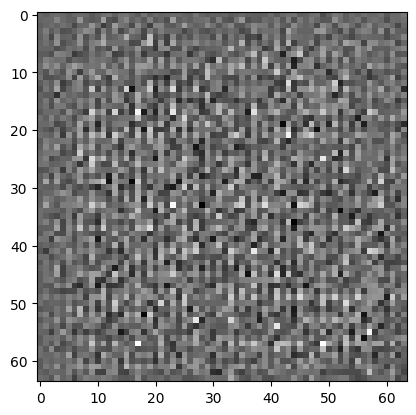

In [27]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [28]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [29]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00045549]], shape=(1, 1), dtype=float32)


In [30]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [31]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [32]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [47]:
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)

In [48]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [49]:
# Training step decorated with tf.function
@tf.function
def train_step(images):
    # This function should not create any new variables
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients and apply optimizers
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop (outside the tf.function)
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

In [50]:
def train(dataset, epochs):
    if checkpoint_manager.latest_checkpoint:
        checkpoint.restore(checkpoint_manager.latest_checkpoint)
        print("Restored from {}".format(checkpoint_manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")

    for epoch in range(epochs):
        start = time.time()

        # Print the current epoch number
        print(f"Epoch {epoch+1}/{epochs}")

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model at the end of every epoch
        checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch + 1} is {time.time() - start:.2f} sec')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [51]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# TRAINING

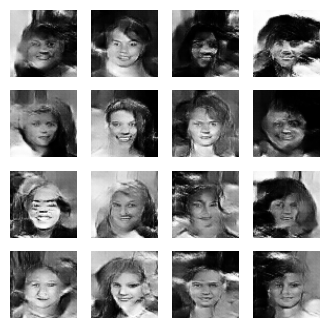

In [52]:
train(train_dataset, EPOCHS)

In [59]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-59-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-59-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



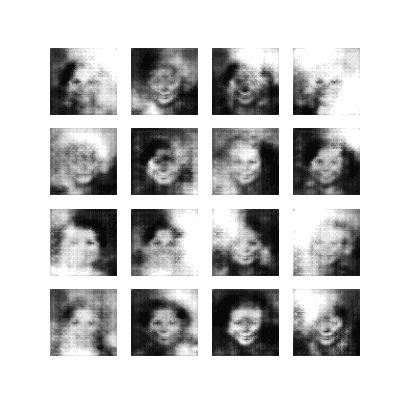

In [60]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [61]:
from google.colab import files

# Download the file
files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>